In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model
import warnings
warnings.filterwarnings(action='ignore')

data = pd.read_csv('/content/drive/MyDrive/FYP Data/Main/Mississippi River CSV.csv')
data = data.drop(['Year', 'Month', 'Day'], axis=1)

def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Prediction':predictions, 'Actual Value':y})
  plt.plot(df['Prediction'][:])
  plt.plot(df['Actual Value'][:])
  return df, mse(y, predictions)

data

,Date,Min Temperature,Max Temperature,Precipitation,Min_Rel Humidity,Max_Rel Humidity,Wind Speed,Vapor Pressure Deficit,Flood
0,1/1/1979,-3.75,11.75,3.8,64.3,98.7,6.2,0.29,False
1,1/2/1979,-8.45,-0.65,0.0,24.5,87.6,6.3,0.26,False
2,1/3/1979,-8.25,3.85,0.0,29.0,76.8,1.5,0.34,False
3,1/4/1979,-5.55,7.85,0.7,29.7,58.8,3.1,0.41,False
4,1/5/1979,-0.15,7.95,13.6,39.0,100.0,3.1,0.22,False
...,...,...,...,...,...,...,...,...,...
16063,12/24/2022,-8.05,0.55,0.0,17.2,36.2,4.0,0.36,False
16064,12/25/2022,-6.65,5.15,0.0,21.0,52.8,1.7,0.42,False
16065,12/26/2022,-4.85,10.45,0.0,19.6,62.8,2.5,0.56,False
16066,12/27/2022,-2.95,11.25,0.0,48.3,100.0,3.1,0.26,False


In [ ]:
data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')

temp_df = pd.DataFrame({'Min Temperature':data['Min Temperature'], 'Max Temperature':data['Max Temperature'], 'Precipitation':data['Precipitation'], 'Min_Rel Humidity':data['Min_Rel Humidity'],
                        'Max_Rel Humidity':data['Max_Rel Humidity'], 'Wind Speed':data['Wind Speed'], 'Vapor Pressure Deficit':data['Vapor Pressure Deficit'], 'Flood':data['Flood']})

le = LabelEncoder()
temp_df['Flood'] = le.fit_transform(temp_df.Flood.values)
scaler = MinMaxScaler()
temp_df[['Min Temperature', 'Max Temperature', 'Precipitation', 'Min_Rel Humidity', 'Max_Rel Humidity', 'Wind Speed', 'Vapor Pressure Deficit',
         'Flood']] = scaler.fit_transform(temp_df[['Min Temperature', 'Max Temperature', 'Precipitation', 'Min_Rel Humidity', 'Max_Rel Humidity', 'Wind Speed', 'Vapor Pressure Deficit', 'Flood']])

temp_df

,Min Temperature,Max Temperature,Precipitation,Min_Rel Humidity,Max_Rel Humidity,Wind Speed,Vapor Pressure Deficit,Flood
Date,,,,,,,,
1979-01-01,0.291391,0.397683,0.018027,0.616129,0.981767,0.504425,0.081690,0.0
1979-01-02,0.187638,0.158301,0.000000,0.188172,0.826087,0.513274,0.073239,0.0
1979-01-03,0.192053,0.245174,0.000000,0.236559,0.674614,0.088496,0.095775,0.0
1979-01-04,0.251656,0.322394,0.003321,0.244086,0.422160,0.230088,0.115493,0.0
1979-01-05,0.370861,0.324324,0.064516,0.344086,1.000000,0.230088,0.061972,0.0
...,...,...,...,...,...,...,...,...
2022-12-24,0.196468,0.181467,0.000000,0.109677,0.105189,0.309735,0.101408,0.0
2022-12-25,0.227373,0.270270,0.000000,0.150538,0.338008,0.106195,0.118310,0.0
2022-12-26,0.267108,0.372587,0.000000,0.135484,0.478261,0.176991,0.157746,0.0


In [ ]:
def df_to_X_y(df, window_size=180):
  df_as_np = df.to_numpy()
  X = []
  y = []

  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][7]
    y.append(label)

  return np.array(X), np.array(y)

X, y = df_to_X_y(temp_df)

X_train, y_train = X[:10000], y[:10000]
X_val, y_val = X[10000:12000], y[10000:12000]
X_test, y_test = X[12000:], y[12000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10000, 180, 8), (10000,), (2000, 180, 8), (2000,), (3888, 180, 8), (3888,))

In [ ]:
model = Sequential()
model.add(InputLayer((180, 8)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18688     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19,217
Trainable params: 19,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

m_checkpoint = ModelCheckpoint('model_MR/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00001), metrics=[RootMeanSquaredError()])
data_err = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[m_checkpoint])

Epoch 1/50
313/313 [==============================] - 34s 98ms/step - loss: 9.6256e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 2/50
313/313 [==============================] - 30s 96ms/step - loss: 9.5730e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 3/50
313/313 [==============================] - 31s 99ms/step - loss: 9.5236e-04 - root_mean_squared_error: 0.0309 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 4/50
313/313 [==============================] - 31s 98ms/step - loss: 9.4996e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 5/50
313/313 [==============================] - 25s 81ms/step - loss: 9.3995e-04 - root_mean_squared_error: 0.0307 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 6/50
313/313 [==============================] - 27s 85ms/step - loss: 9.3820e-04 - root_mean_squared_err

122/122 [==============================] - 3s 22ms/step


(      Prediction  Actual Value
 0      -0.005712           0.0
 1      -0.004512           0.0
 2      -0.001246           0.0
 3      -0.002189           0.0
 4       0.002663           0.0
 ...          ...           ...
 3883    0.006897           0.0
 3884    0.010127           0.0
 3885    0.011682           0.0
 3886    0.013149           0.0
 3887    0.003882           0.0
 
 [3888 rows x 2 columns], 0.0037830915278592382)

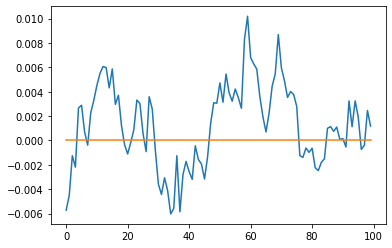

In [ ]:
model = load_model('model_MR/')

plot_predictions(model, X_test, y_test)

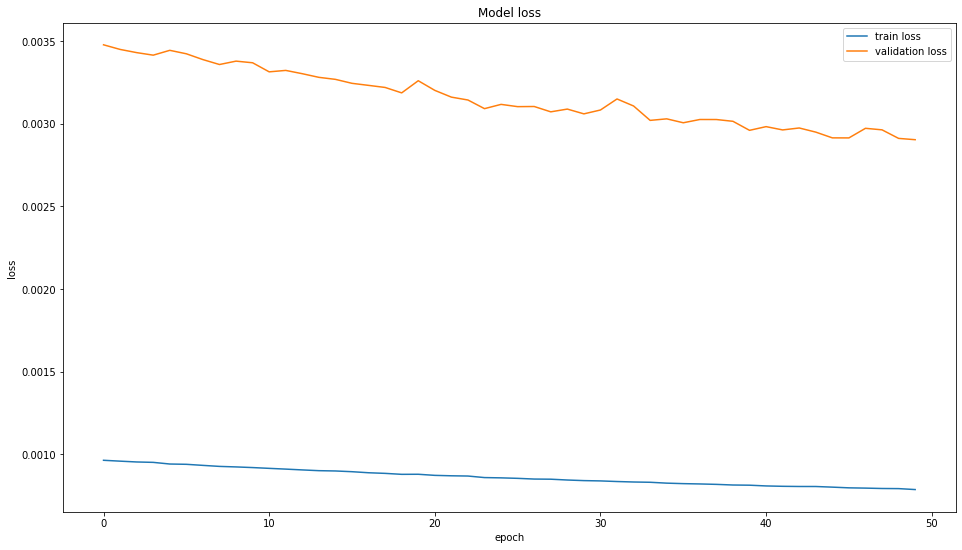

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(data_err.history['loss'])
plt.plot(data_err.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()